### Perfiles radiales de Fe/H en bines de edad

subhalo_127000000000002


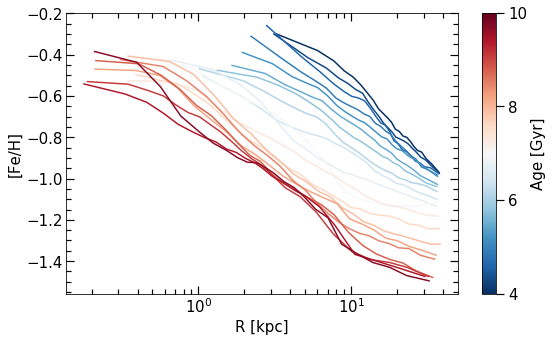

subhalo_127000000000003


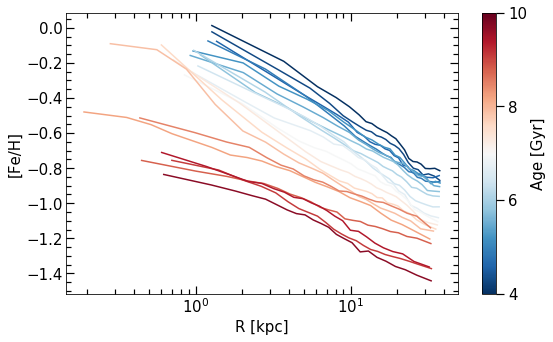

subhalo_127000000000004


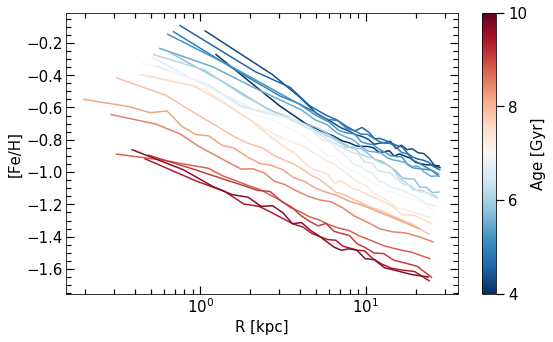

subhalo_127000000000006


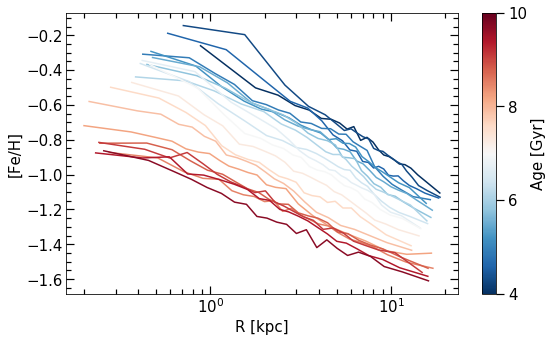

subhalo_127000000000007


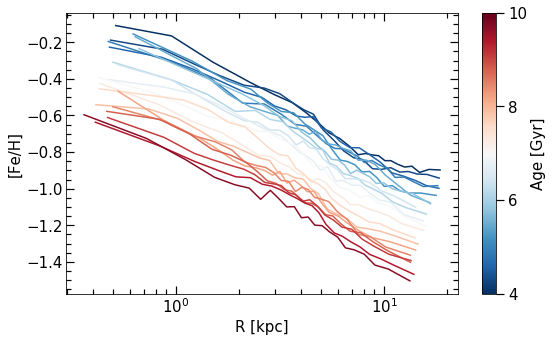

subhalo_127000000000009


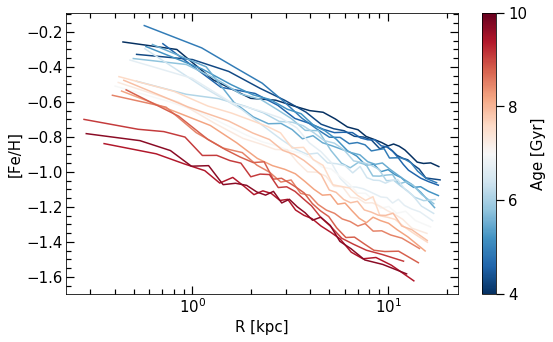

subhalo_127000000000012


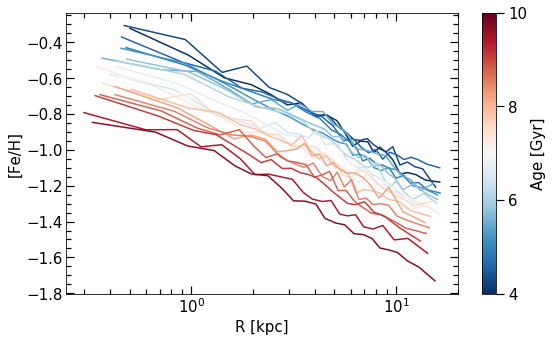

subhalo_127000000000011


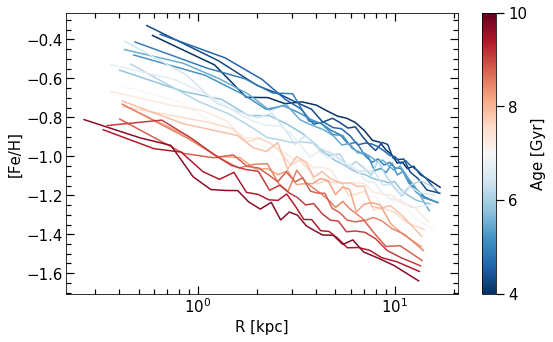

subhalo_127000000000014


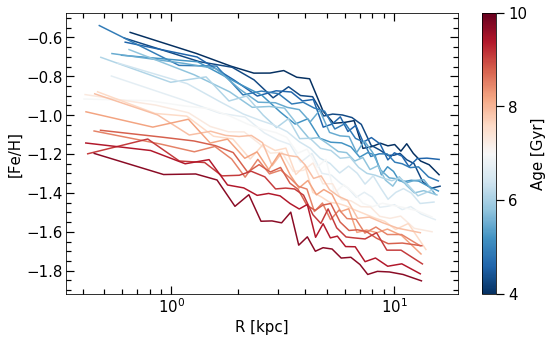

subhalo_127000000000020


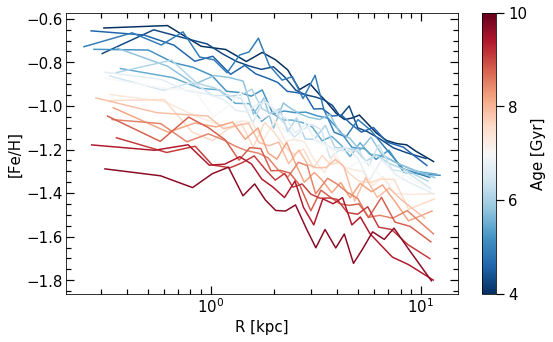

subhalo_127000000000021


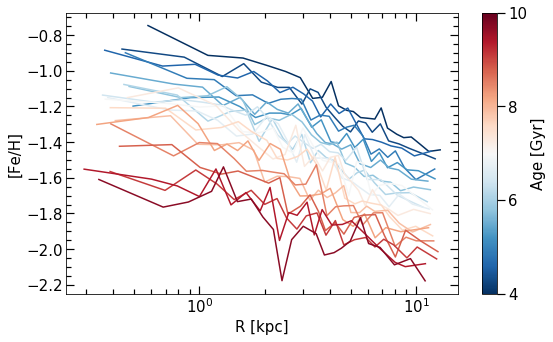

subhalo_127000000000023


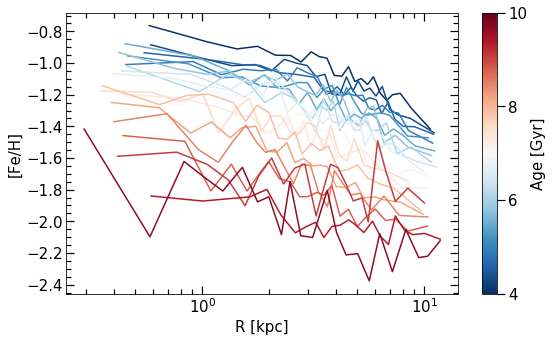

In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import time_conversion as time
import bines2 as bines
import matplotlib as mpl
import metallicity_profile as metp

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/z/omarioni/gradients/_simulations/snap_127/'

for j in range(12):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[j])+'.h5py', 'r')

    print('subhalo_'+str('%d'%ID[j]))

    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]

    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]

    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]

    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)

    FeH_ = met[amask,8]/met[amask,0]
    FeH  = FeH_/0.0127

    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)

    #----------------------masas----------------------------
    mstr = mstr[amask]*1e10/h

    rgal = 0.15*Rvir*aexp/h

    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]

    veloc,=np.where(rstr < r50/2.)

    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)

    xn  = e1x*xstr + e1y*ystr + e1z*zstr
    yn  = e2x*xstr + e2y*ystr + e2z*zstr
    zn  = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    rn = np.sqrt(xn**2 + yn**2 + zn**2 )

    limit2, = np.where(rn < rgal)

    age_ = age[limit2]

    #     edades, = np.where((age_>4) & (age_<10))
    x_str = xn[limit2]
    y_str = yn[limit2]
    z_str = zn[limit2]
    FeH   = FeH[limit2]

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
    fig.subplots_adjust(bottom=0.15, left =0.12, right = 0.97, top = 0.93, wspace=0., hspace= 0)


    nb = 20

    delta = (10.-4.)/nb
    rango = np.arange(4,10,delta)

    #Esto es para la barra de colores
    color_range = np.linspace(4,10,nb)
    norm = mpl.colors.Normalize(vmin = color_range.min(),vmax= color_range.max())
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap = 'RdBu_r')

    for i in rango:

        agelim = np.where((age_>i) & (age_<i+delta))

        R = np.sqrt(x_str[agelim]**2 + y_str[agelim]**2)
        z = z_str[agelim]
        FH = FeH[agelim]

        nbin = 23

        kk,  = np.where(FH>0)
#         print(len(kk))

        med, Fe_H = metp.met(R[kk],z[kk],np.log10(FH[kk]),nbin)

        ax.plot(med,Fe_H, ls='-',color = cmap.to_rgba(i))

    cbar = fig.colorbar(cmap,ticks=[4,6,8,10]) #pad=0.01)
    cbar.set_label('Age [Gyr]',fontsize=15)
    cbar.ax.tick_params( labelsize=15)
    cbar.ax.tick_params(length=8, width=1.2, which='major')

    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=5, width=1.2,which='minor', direction='in', right='on',top='on')
    ax.tick_params('both', length=8, width=1.2,which='major', direction='in', right='on',top='on')
    # ax.set_xlim(0,14)
    ax.set_ylabel('[Fe/H]',fontsize=15)
    ax.set_xlabel('R [kpc]',fontsize=15)
    #     ax.legend(fontsize=15,frameon=False)

    plt.show()

    fig.savefig('../_imagenes/met_perfil/met_subh_'+str('%d'%ID[j])+'.png',dpi=100, xxbox_inches='tight')